## Imports

In [1]:
import sentencepiece as spm
import torch
from thop import profile
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
from safetensors.torch import load_model
import random
import json

# local imports
from model import GPT
from inference import generate, text_to_token_ids, token_ids_to_text
from eval import calc_loss_batch
from data import create_dataloader

## Config

In [ ]:
with open("results/trained_models/3M/config.json", "r") as f:
    config = json.load(f)

device = "cpu"

model = GPT(config["model"])
load_model(model, "archive/xs_model.safetensors")
model.to(device)
model.eval()

## Model Size & Compute

In [4]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

Total number of parameters: 58,868,736


In [5]:
input_tensor = torch.randint(0, config["model"]["vocab_size"], (1, config["model"]["context_length"])).to(device)
    
# MACS = multiply-accumulate operations
# MACS are typically counted as two FLOPS (one multiply and one accumulate)
macs, params = profile(model, inputs=(input_tensor,), verbose=False)
flops = 2*macs
print(f"{flops:.2e} FLOPS per inference token")

1.40e+10 FLOPS per inference token


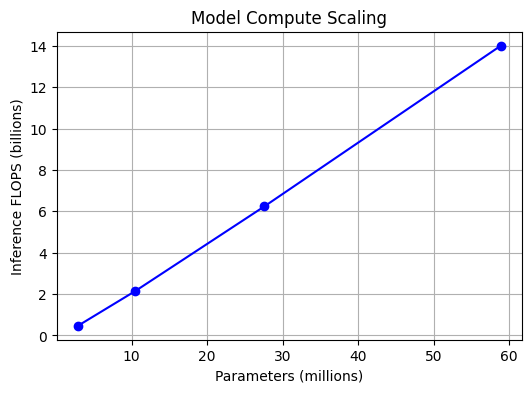

In [41]:
# Data
parameters = [2.9, 10.5, 27.6, 58.9]
flops = [0.47, 2.15, 6.24, 14.0]

# Plotting
plt.figure(figsize=(6, 4))
plt.plot(parameters, flops, marker='o', linestyle='-', color='b')
plt.title('Model Compute Scaling')
plt.xlabel('Parameters (millions)')
plt.ylabel('Inference FLOPS (billions)')
plt.grid(True)
plt.show()

## Performance

In [ ]:
def calc_loss_loader(data_loader, model, device):
    total_loss = 0.
    for batch in tqdm(data_loader):
        loss = calc_loss_batch(batch, model, device)
        total_loss += loss.item()
    return total_loss / len(data_loader)

train_loader = create_dataloader("training_data/train_subset.txt", batch_size=8, shuffle=False)
val_loader = create_dataloader("training_data/validation.txt", batch_size=8, shuffle=False)

with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)
    print(f"Train loss: {train_loss:.3f} | Val loss: {val_loss:.3f}")

| Parameters (e6) | FLOPs (e9) | Train Loss | Val Loss |
|-----------------|------------|------------|----------|
| 2.9             | 0.47       | 1.866      | 1.881    |
| 10.5            | 2.15       | 1.499      | 1.526    |
| 27.6            | 6.24       | 1.325      | 1.362    |
| 58.9            | 14.0       | 1.266      | 1.309    |

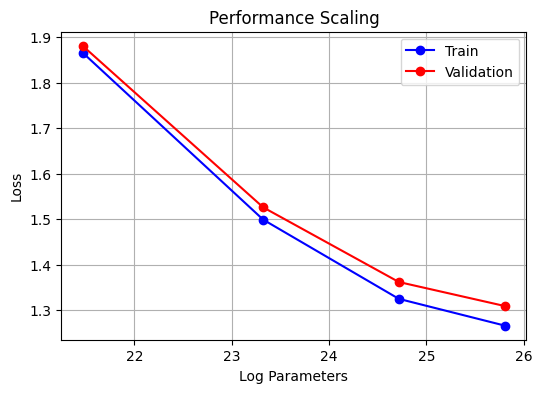

In [248]:
# Data
parameters = [math.log(x, 2) for x in [2.9e6, 10.5e6, 27.6e6, 58.9e6]]
train_loss = [1.866, 1.499, 1.325, 1.266]
val_loss = [1.881, 1.526, 1.362, 1.309]

# Plotting
plt.figure(figsize=(6, 4))
plt.plot(parameters, train_loss, label='Train', marker='o', color='b')
plt.plot(parameters, val_loss, label='Validation', marker='o', color='r')

# Labels and title
plt.xlabel('Log Parameters')
plt.ylabel('Loss')
plt.title('Performance Scaling')
plt.legend()
plt.grid(True)
plt.show()

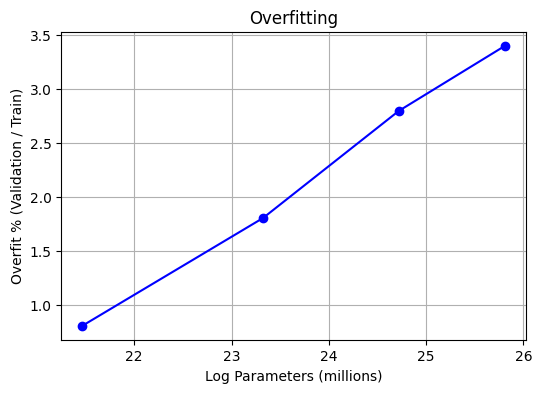

In [43]:
# Data
parameters = [math.log(x, 2) for x in [2.9e6, 10.5e6, 27.6e6, 58.9e6]]
train_loss = [1.866, 1.499, 1.325, 1.266]
val_loss = [1.881, 1.526, 1.362, 1.309]
overfit = [100*(val_loss[i] / train_loss[i] - 1) for i in range(len(val_loss))]


# Plotting
plt.figure(figsize=(6, 4))
plt.plot(parameters, overfit, marker='o', color='b')

# Labels and title
plt.xlabel('Log Parameters (millions)')
plt.ylabel('Overfit % (Validation / Train)')
plt.title('Overfitting')
plt.grid(True)
plt.show()

## Text Samples

### Inference Parameter (Temperature, TopK) Search

In [8]:
tokenizer = spm.SentencePieceProcessor(
    model_file=f'tokenizers/tinynewstokenizer{config["model"]["vocab_size"]}.model')

In [52]:
inference_parameter_search = {}

for model_size in ("8b", "70b"):
    validation_bulletins = []
    with open(f'training_data/validation_{model_size}.txt', 'r') as f:
        for line in f:
            validation_bulletins.append(line.strip())

    inference_parameter_search[f"{model_size}_original"] = random.choices(validation_bulletins, k=128)

In [75]:
for model_size in ("8b", "70b"):
    for temperature, top_k in ((0, None), (0.5, 16), (1.0, 32)):
        inference_parameter_search[f"{model_size}_temp_{temperature}_topk_{top_k}"] = []

In [76]:
for model_size in ("8b", "70b"):

    for bulletin in tqdm(inference_parameter_search[f"{model_size}_original"]):
            
        for temperature, top_k in ((0, None), (0.5, 16), (1.0, 32)):

            token_ids = generate(
                model=model,
                idx=text_to_token_ids(bulletin.split("</h>")[0] + "</h>", tokenizer).to(device),
                context_length=config["model"]["context_length"],
                top_k=top_k,
                temperature=temperature,
                eos_id=2
            )

            inference_parameter_search[f"{model_size}_temp_{temperature}_topk_{top_k}"].extend(
                [token_ids_to_text(token_ids, tokenizer)])

100%|██████████| 128/128 [17:58<00:00,  8.43s/it]


In [77]:
# with open("results/70b_as_judge/inference_parameter_evaluation.json", "w") as f:
#     json.dump(inference_parameter_search, f, indent=4)

In [28]:
with open("results/70b_as_judge/inference_parameter_evaluation.json", "r") as f:
    inference_parameter_evaluation = json.load(f)

In [31]:
evaluations = {}
for params in inference_parameter_evaluation:
    evaluations[params] = []
    for score in inference_parameter_evaluation[params]:
        try:
            evaluations[params].append(json.loads('{"notes": "' + score)['evaluation'])
        except:
            evaluations[params].append(int(score[-2]))

In [32]:
for params, scores in evaluations.items():
    print(f"{params:>20}: {sum(scores) / len(scores):.3f}")

         8b_original: 4.867
        70b_original: 4.953
 8b_temp_0_topk_None: 3.945
 8b_temp_0.5_topk_16: 3.891
 8b_temp_1.0_topk_32: 3.426
70b_temp_0_topk_None: 4.023
70b_temp_0.5_topk_16: 4.125
70b_temp_1.0_topk_32: 3.484


In [35]:
combined = evaluations["8b_original"] + evaluations["70b_original"]
equal_or_larger = 0
for _ in range(1000):
    sample = random.choices(combined, k=128)
    sample_score = sum(sample) / len(sample)
    if sample_score >= 4.953 or sample_score <= 4.867:
        equal_or_larger += 1
print(f"70B vs 8B p-value: {equal_or_larger / 1000:.3f}")

70B vs 8B p-value: 0.094


In [36]:
combined = evaluations["70b_temp_0_topk_None"] + evaluations["70b_temp_1.0_topk_32"]
equal_or_larger = 0
for _ in range(1000):
    sample = random.choices(combined, k=128)
    sample_score = sum(sample) / len(sample)
    if sample_score >= 4.023 or sample_score <= 3.484:
        equal_or_larger += 1
print(f"0 Temp vs. 1.0 Temp p-value: {equal_or_larger / 1000:.3f}")

0 Temp vs. 1.0 Temp p-value: 0.006


### Generating sample text for the remaining models using Temp=0

In [145]:
models = {
    "xs_model": xs_model,
    "s_model": s_model,
    "m_model": m_model
}

text_gen_samples_xs_s_m = {}

for model_name, gen_model in models.items():

    text_gen_samples_xs_s_m[model_name] = []

    for bulletin in tqdm(inference_parameter_search["70b_original"]):

        token_ids = generate(
            model=gen_model,
            idx=text_to_token_ids(bulletin.split("</h>")[0] + "</h>", tokenizer).to(device),
            context_length=config["model"]["context_length"],
            top_k=None,
            temperature=0,
            eos_id=2
        )

        text_gen_samples_xs_s_m[model_name].extend(
            [token_ids_to_text(token_ids, tokenizer)])

100%|██████████| 128/128 [03:07<00:00,  1.46s/it]


In [146]:
# with open("results/70b_as_judge/text_gen_samples_xs_s_m.json", "w") as f:
#     json.dump(text_gen_samples_xs_s_m, f, indent=4)

In [171]:
with open("results/70b_as_judge/text_gen_xs_s_m_evaluation.json", "r") as f:
    text_gen_xs_s_m_evaluation = json.load(f)

In [172]:
for params in text_gen_xs_s_m_evaluation:
    evaluations[params] = []
    for score in text_gen_xs_s_m_evaluation[params]:
        try:
            evaluations[params].append(json.loads('{"notes": "' + score)['evaluation'])
        except:
            print(score[-2])
            evaluations[params].append(int(score[-2]))

In [174]:
for params, scores in evaluations.items():
    print(f"{params:>20}: {sum(scores) / len(scores):.3f}")

         8b_original: 4.867
        70b_original: 4.953
 8b_temp_0_topk_None: 3.945
 8b_temp_0.5_topk_16: 3.891
 8b_temp_1.0_topk_32: 3.426
70b_temp_0_topk_None: 4.023
70b_temp_0.5_topk_16: 4.125
70b_temp_1.0_topk_32: 3.484
            xs_model: 2.945
             s_model: 3.555
             m_model: 4.000


In [179]:
evaluations['l_model'] = evaluations['70b_temp_0_topk_None']
for key in ('70b_temp_0_topk_None', '70b_temp_0.5_topk_16', '70b_temp_1.0_topk_32', '8b_temp_0_topk_None', '8b_temp_0.5_topk_16', '8b_temp_1.0_topk_32'):
    evaluations.pop(key)

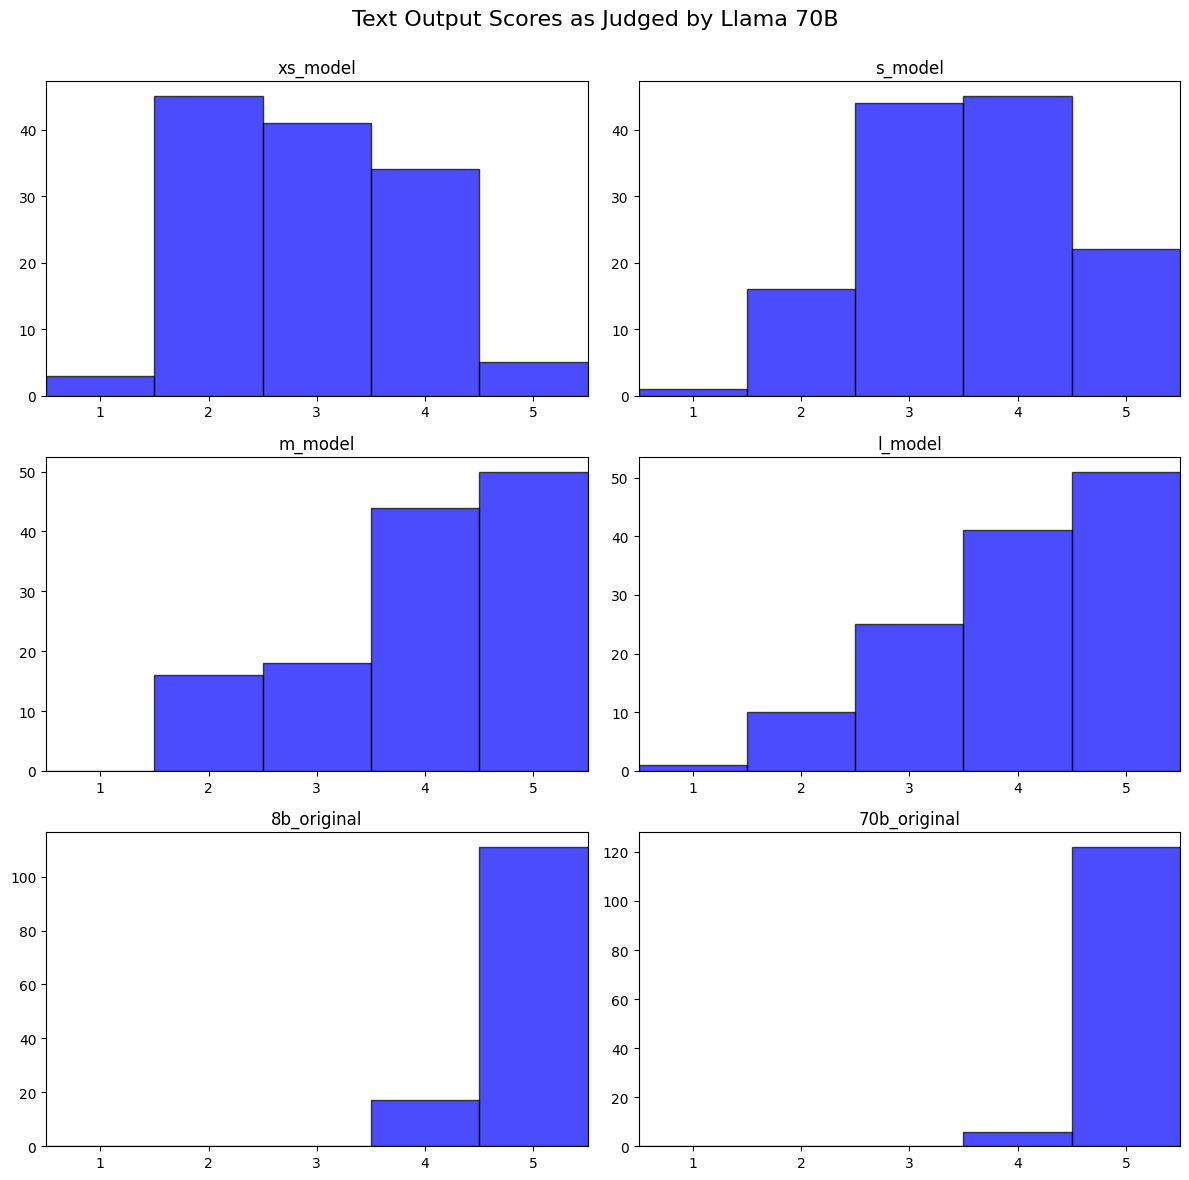

In [201]:
# plot histograms
fig, axs = plt.subplots(3, 2, figsize=(12, 12))

for i, model_name in enumerate(("xs_model", "s_model", "m_model", "l_model", "8b_original", "70b_original")):
    ax = axs[i // 2, i % 2]
    ax.hist(evaluations[model_name], bins=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5], color='b', alpha=0.7, edgecolor='black', align='mid')
    ax.set_title(f"{model_name}")
    ax.set_xticks([1, 2, 3, 4, 5])
    ax.set_xlim(0.5, 5.5)

fig.suptitle("Text Output Scores as Judged by Llama 70B", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.98])  # Adjust layout to make room for the title
plt.show()

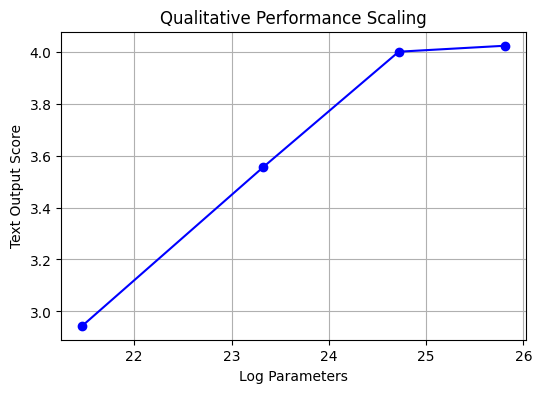

In [210]:
# Data
parameters = [math.log(x, 2) for x in [2.9e6, 10.5e6, 27.6e6, 58.9e6]]
score = [2.945, 3.555, 4.000, 4.023]

# Plotting
plt.figure(figsize=(6, 4))
plt.plot(parameters, score, marker='o', color='b')

# Labels and title
plt.xlabel('Log Parameters')
plt.ylabel('Text Output Score')
plt.title('Qualitative Performance Scaling')
plt.grid(True)
plt.show()

In [245]:
def print_example_generations(i):
    print(inference_parameter_search['70b_temp_0_topk_None'][i].split("</h>")[0])
    print()
    for gen_model in ("xs_model", "s_model", "m_model"):
        print(gen_model, evaluations[gen_model][i])
        print(text_gen_samples_xs_s_m[gen_model][i].split("</h>")[1].replace(".", "\n"))
        print()
    print("l_model", evaluations['l_model'][i])
    print(inference_parameter_search['70b_temp_0_topk_None'][i].split("</h>")[1].replace(".", "\n"))
    print("70b_original", evaluations['70b_original'][i])
    print(inference_parameter_search['70b_original'][i].split("</h>")[1].replace(".", "\n"))

In [246]:
print_example_generations(60)

family enjoys travelling around the world 

xs_model 2
 a family has been enjoying the travelling around the world
 they have been enjoying the sights and sounds of the sights and sounds of the sights
 the family is grateful for the opportunity to explore the world and learn about the world
 the family is grateful for the opportunity to spend time together and make new memories


s_model 4
 a family has been enjoying a trip around the world, enjoying the beautiful scenery and company of their trip
 the family has been planning their trip for months, and they have been taking in the sights and sounds of the world
 the trip has been a huge success, and the family is grateful for the opportunity to spend quality time together
 they are already planning their next trip


m_model 3
 a family of four has been traveling around the world for several months, enjoying the beautiful scenery and each other's company
 they have been traveling for over 10 years, and have seen many different cultures

## Self-Prompting

In [6]:
self_prompt_samples_temp_1_topk_32 = {"l_model": [], "m_model": [], "s_model": [], "xs_model": []}

In [16]:
for bulletin in tqdm(range(128)):

    token_ids = generate(
        model=model,
        idx=text_to_token_ids("", tokenizer).to(device),
        context_length=config["model"]["context_length"],
        top_k=32,
        temperature=1.0,
        eos_id=2
    )

    self_prompt_samples_temp_1_topk_32["xs_model"].extend(
        [token_ids_to_text(token_ids, tokenizer)])

100%|██████████| 128/128 [00:23<00:00,  5.47it/s]


In [17]:
with open("results/70b_as_judge/self_prompt_samples_temp_1_topk_32.json", "w") as f:
    json.dump(self_prompt_samples_temp_1_topk_32, f, indent=4)

In [18]:
with open("results/70b_as_judge/self_prompt_samples_temp_1_topk_32_evaluation.json", "r") as f:
    self_prompt_samples_temp_1_topk_32_evaluation = json.load(f)

In [39]:
self_prompt_evaluations = {}
for _model in self_prompt_samples_temp_1_topk_32_evaluation:
    self_prompt_evaluations[_model] = []
    for eval in self_prompt_samples_temp_1_topk_32_evaluation[_model]:
        try:
            self_prompt_evaluations[_model].append(json.loads('{"notes": "' + eval)['evaluation'])
        except:
            print(eval[-2])
            self_prompt_evaluations[_model].append(int(eval[-2]))

In [40]:
for _model, scores in self_prompt_evaluations.items():
    print(f"{_model:>20}: {sum(scores) / len(scores):.3f}")

             l_model: 3.668
             m_model: 3.664
             s_model: 3.188
            xs_model: 2.445


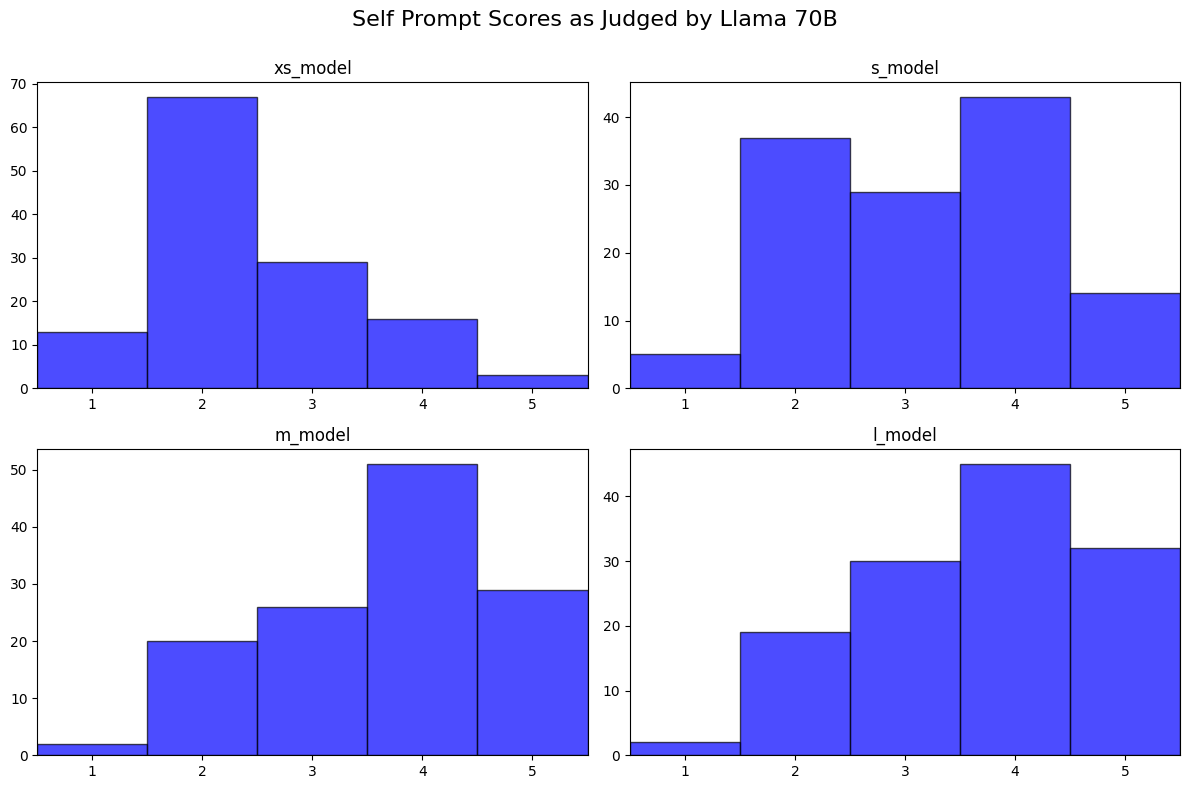

In [24]:
# plot histograms
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

for i, model_name in enumerate(("xs_model", "s_model", "m_model", "l_model")):
    ax = axs[i // 2, i % 2]
    ax.hist(evaluations[model_name], bins=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5], color='b', alpha=0.7, edgecolor='black', align='mid')
    ax.set_title(f"{model_name}")
    ax.set_xticks([1, 2, 3, 4, 5])
    ax.set_xlim(0.5, 5.5)

fig.suptitle("Self Prompt Scores as Judged by Llama 70B", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.98])  # Adjust layout to make room for the title
plt.show()

In [42]:
combined = self_prompt_evaluations["l_model"] + evaluations["70b_temp_1.0_topk_32"]
equal_or_larger = 0
for _ in range(1000):
    sample = random.choices(combined, k=128)
    sample_score = sum(sample) / len(sample)
    if sample_score >= 3.668 or sample_score <= 3.484:
        equal_or_larger += 1
print(f"1.0 Temp: Self vs. 70B Prompt p-value: {equal_or_larger / 1000:.3f}")

1.0 Temp: Self vs. 70B Prompt p-value: 0.356


## Annealing with 70B Data

In [45]:
loader_8b = create_dataloader("training_data/validation_8b.txt", batch_size=8, shuffle=False)
loader_70b = create_dataloader("training_data/validation_70b.txt", batch_size=8, shuffle=False)

with torch.no_grad():
    train_loss = calc_loss_loader(loader_8b, model, device)
    val_loss = calc_loss_loader(loader_70b, model, device)
    print(f"8b loss: {train_loss:.3f} | 70b loss: {val_loss:.3f}")

100%|██████████| 255/255 [00:47<00:00,  5.35it/s]

8b loss: 1.294 | 70b loss: 1.371


Control Model:

8b loss: 1.294 | 70b loss: 1.371

## Other Experiments

### Decay Methods

| Method  | Train Loss | Val Loss |
|---------|------------|----------|
| Cosine  | 1.969      | 1.982    |
| Linear  | 1.972      | 1.985    |
| WSD     | 1.991      | 2.004    |

### Doubling Layers & Heads of 10.5 Model

| Variation | Train Loss | Val Loss |
|-----------|-------------|----------|
| 8H & 8L   | 1.499       | 1.526    |
| 16 Heads  | 1.514       | 1.541    |
| 16 Layers | 1.440       | 1.470    |